In [1]:
!pip install gym==0.15.3

In [2]:
import random
import numpy as np
import random
import gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from IPython.display import clear_output
import time

In [3]:
'''
The environment used here is extremely similar to the openai gym ones.
At first glance it might look slightly different.
The usual commands we use for our experiments are added to this cell to aid you
work using this environment.
'''

#Setting up the environment
env = gym.make('Taxi-v3')

env.reset()

#Current State
print(env.s)

# 5x5x5x4 grid = 500 states
print ("Number of states:", env.observation_space.n)

# Primitive Actions
action = ["south", "north", "east", "west","pick","drop"]
#correspond to [0,1,2,3,4,5] that's actually passed to the environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.action_space.n)

# Example Transitions
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)

state = env.reset()
print ("Decoded state:", list(env.decode(state)))
env.render()


44
Number of states: 500
Number of actions that an agent can take: 6
Action taken: east
Transition probability: {'prob': 1.0}
Next state: 64
Reward recieved: -1
Terminal state: False
Decoded state: [1, 3, 3, 2]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [4]:
def stateData(state):
  picdrop = state%20
  pos = state//20
  y = pos//5
  x = pos%5
  drop = picdrop%4
  passenger = picdrop//4
  return x,y,drop,passenger

In [5]:
def egreedy_policy(q_values,state,epsilon):
  if q_values[state].any() and random.random() > epsilon:
    return np.argmax(q_values[state])
  else:
    return np.random.randint(len(q_values[state]))


In [6]:
# Number of options
num_options = 4

# Goal locations
goals = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}

# Define option function
def Options_frame(env, state, Q, goal_num, eps=0.1, goals=goals):
    opt_done = False
    x, y, passenger, dropoff = env.decode(state)

    if (x == goals[goal_num][0] and y == goals[goal_num][1]):
        opt_done = True
        if passenger == goal_num:
            opt_act = 4  # pick up passenger
        elif dropoff == goal_num:
            opt_act = 5  # drop off passenger
        else:
            # Move south or north depending on the goal color
            opt_act = 1 if (goal_num in [0,1]) else 0
    else:
        opt_act = egreedy_policy(Q[goal_num],  5*x+y, eps)

    return [opt_act, opt_done]

'''
Now the new action space will contain
Primitive Actions: ["south", "north", "east", "west","pick","drop"]
Options: ["OptionR","OptionG","OptionY","OptionB"]
Total Actions :["south", "north", "east", "west","pick","drop","OptionR","OptionG","OptionY","OptionB"]
Corresponding to [0,1,2,3,4,5,6,7,8,9]
'''

'\nNow the new action space will contain\nPrimitive Actions: ["south", "north", "east", "west","pick","drop"]\nOptions: ["OptionR","OptionG","OptionY","OptionB"]\nTotal Actions :["south", "north", "east", "west","pick","drop","OptionR","OptionG","OptionY","OptionB"]\nCorresponding to [0,1,2,3,4,5,6,7,8,9]\n'

## SMDP Q-learning

In [7]:
rewards = []  # To store rewards per episode
goal_positions = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}  # Goal positions for passengers and drops

# Parameters
gamma = 0.9  # Discount factor
alpha = 0.1  # Learning rate

# Initialize Q-table for SMDP
n_x = 5
n_y = 5
n_passenger = 5
n_drops = 4
n_options = 4
q_values_SMDP = np.zeros((n_passenger * n_drops, n_options))
updates_SMDP = np.zeros((n_passenger * n_drops, n_options))

# Initialize Q-values for each option
Q_options = {i: np.zeros((n_x * n_y, env.action_space.n - 2)) for i in range(n_options)}  # Subtracting pick,drop

In [8]:
def SMDP_QLearning(render = None):
    # While episode is not over
    global count_success,eps_main
    state = env.reset()
    rewards = []
    done = False
    total_reward = 0
    T=1
    while not done:
        x, y, passenger, dropoff = env.decode(state)
        sub_state = n_drops * passenger + dropoff

        # Choose option
        option = egreedy_policy(q_values_SMDP, sub_state, epsilon=eps_main)
        eps_main = max(eps_min, eps_decay * eps_main)
        reward_bar = 0
        opt_done = False
        move = 0
        prev_state = state

        x,y,passenger,dropoff = env.decode(state)

        # Execute option
        while not opt_done and not done:
            opt_act, opt_done = Options_frame(env, state, Q_options, option, eps_options[option])

            [x,y,_,_]=  list(env.decode(state))
            next_state, reward, done, _ = env.step(opt_act)
            [x1,y1,_,_]=  list(env.decode(next_state))

            if render is not None:
                clear_output(wait=True)
                print(env.render())
                time.sleep(T)

            reward_bar = gamma * reward_bar + reward
            move += 1
            total_reward += reward


            # Update option epsilon for exploration
            eps_options[option] = max(eps_min, eps_decay * eps_options[option])

            if opt_done:
                reward_surr = 10
            else:
                reward_surr = reward

            if opt_act < 4:
                Q_options[option][5 * x + y, opt_act] += alpha * (reward_surr + gamma * np.max(Q_options[option][5 * x1 + y1, :]) - Q_options[option][5 * x + y, opt_act])

            state = next_state

        # Update SMDP Q-value
        _, _, passenger, dropoff = env.decode(state)
        sub_state = n_drops * passenger + dropoff

        _, _, passenger, dropoff = env.decode(prev_state)
        sub_prev_state = n_drops * passenger + dropoff

        q_values_SMDP[sub_prev_state, option] += alpha * (reward_bar + (gamma ** move) * np.max(q_values_SMDP[sub_state, :]) - q_values_SMDP[sub_prev_state, option])
        updates_SMDP[sub_prev_state, option] += 1

    rewards.append(total_reward)

    # Check if passenger dropped off successfully
    x, y, passenger, dropoff = env.decode(state)
    if passenger == dropoff and render is None:
        count_success += 1
        # clear_output(wait=True)
        print('Success ({}/{}) = {}%'.format(count_success, i + 1, 100 * count_success / (i + 1)))

    return rewards


In [115]:
goal_positions = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}  # Goal positions for passengers and drops

# Parameters
gamma = 0.9  # Discount factor
alpha = 0.1  # Learning rate

# Initialize Q-table for SMDP
n_x = 5
n_y = 5
n_passenger = 5
n_drops = 4
n_options = 4
q_values_SMDP = np.zeros((n_passenger * n_drops, n_options))
updates_SMDP = np.zeros((n_passenger * n_drops, n_options))

# Initialize Q-values for each option
Q_options = {i: np.zeros((n_x * n_y, env.action_space.n - 2)) for i in range(n_options)}  # Subtracting pick,drop
num_episodes = 1500 # Number of episodes

rewards = []  # To store rewards per episode

# Epsilon-greedy exploration parameters
eps_options = {i: 0.01 for i in range(n_options)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.9
count_success = 0

# # Iterate over episodes
for i in range(num_episodes):
    rewards.append(SMDP_QLearning())
# SMDP_QLearning(render = True)

Success (1/3) = 33.333333333333336%
Success (2/10) = 20.0%
Success (3/17) = 17.647058823529413%
Success (4/19) = 21.05263157894737%
Success (5/20) = 25.0%
Success (6/21) = 28.571428571428573%
Success (7/25) = 28.0%
Success (8/28) = 28.571428571428573%
Success (9/29) = 31.03448275862069%
Success (10/30) = 33.333333333333336%
Success (11/31) = 35.483870967741936%
Success (12/32) = 37.5%
Success (13/33) = 39.39393939393939%
Success (14/34) = 41.1764705882353%
Success (15/35) = 42.857142857142854%
Success (16/36) = 44.44444444444444%
Success (17/37) = 45.945945945945944%
Success (18/38) = 47.36842105263158%
Success (19/39) = 48.717948717948715%
Success (20/40) = 50.0%
Success (21/41) = 51.21951219512195%
Success (22/42) = 52.38095238095238%
Success (23/43) = 53.48837209302326%
Success (24/44) = 54.54545454545455%
Success (25/45) = 55.55555555555556%
Success (26/46) = 56.52173913043478%
Success (27/47) = 57.4468085106383%
Success (28/48) = 58.333333333333336%
Success (29/49) = 59.1836734693

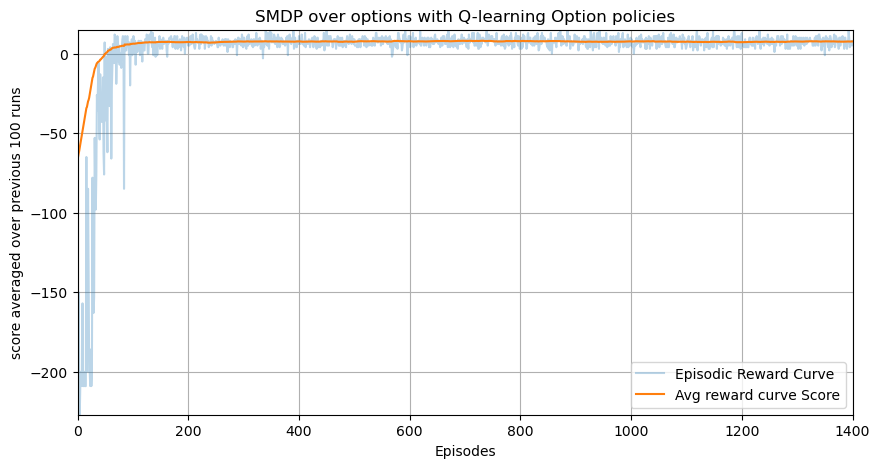

In [188]:
plt.figure(figsize = (10,5))
avg_rews = [np.average(rewards[i:i+100]) for i in range(len(rewards)-100)]
# plt.plot([9.7 for i in range(len(avg_rews))],label = 'Solved line')
plt.plot(rewards,label = 'Episodic Reward Curve', alpha=0.3)
plt.plot(avg_rews,label = 'Avg reward curve Score')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('SMDP over options with Q-learning Option policies')
plt.ylim([np.min(rewards),np.max(rewards)])
plt.xlim([0,1400])
plt.legend()
plt.grid()

In [33]:

SMDP_QLearning(render = True)


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
None


[2]

In [35]:
from matplotlib.colors import ListedColormap

def HeatMapPlot(Q_val, title):
    # Define labels for the actions
    labels = {0: 'goto R', 1: 'goto G', 2: 'goto Y', 3: 'goto B'}

    # Map action indices to action labels
    annot_text = np.vectorize(labels.get)(Qmax_SMDP)
    # Define RGB values for each color
    colors = {'goto R': 'red', 'goto G': 'green', 'goto Y': 'yellow', 'goto B': 'blue'}

    # Create a custom colormap based on the defined colors
    cmap = ListedColormap([colors[label] for label in ['goto R', 'goto G', 'goto Y', 'goto B']])

    # Create heatmap
    figure, axis = plt.subplots(1, 1, figsize=(10, 10))
    ax = sns.heatmap(Qmax_SMDP, ax=axis, xticklabels=["R", "G", "Y", "B"],
                 yticklabels=['R', 'G', 'Y', 'B', 'Taxi'], annot=annot_text, fmt='', cmap=cmap)


    # Customize colorbar ticks and labels
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([0, 1, 2, 3])
    c_bar.set_ticklabels(['goto R', 'goto G', 'goto Y', 'goto B'])

    # Set axis labels and title
    axis.set_xlabel('Drop off points')
    axis.set_ylabel("Passenger location")
    axis.set_title(title)


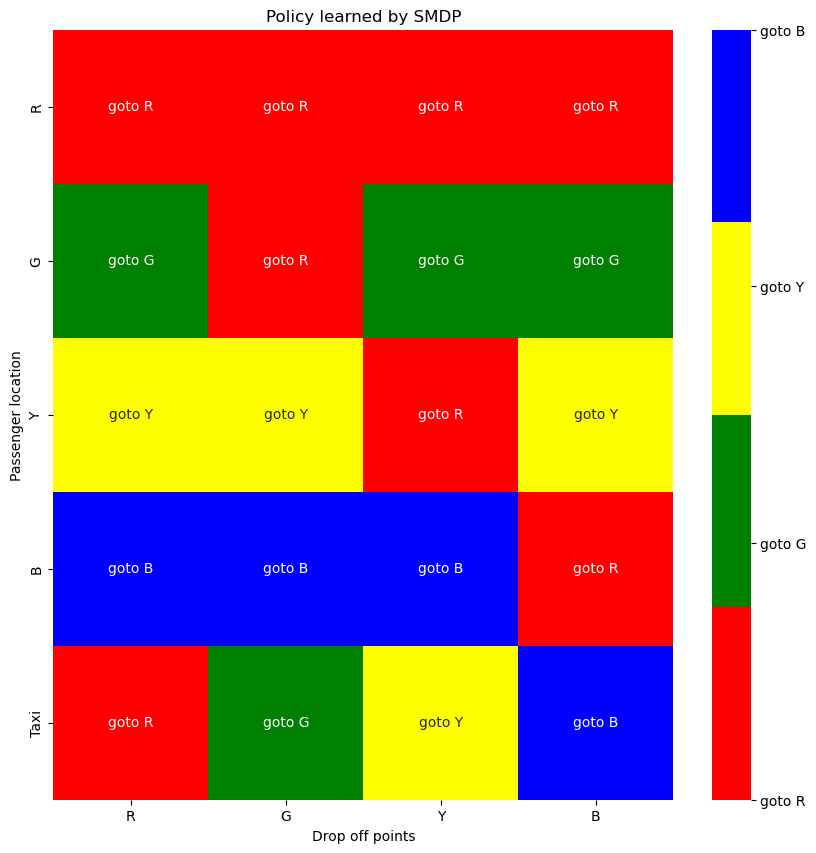

In [36]:

# Find the action index with maximum Q-value for each state
Qmax_SMDP = np.argmax(q_values_SMDP, axis=1).reshape(5, 4)
HeatMapPlot(Qmax_SMDP, 'Policy learned by SMDP')


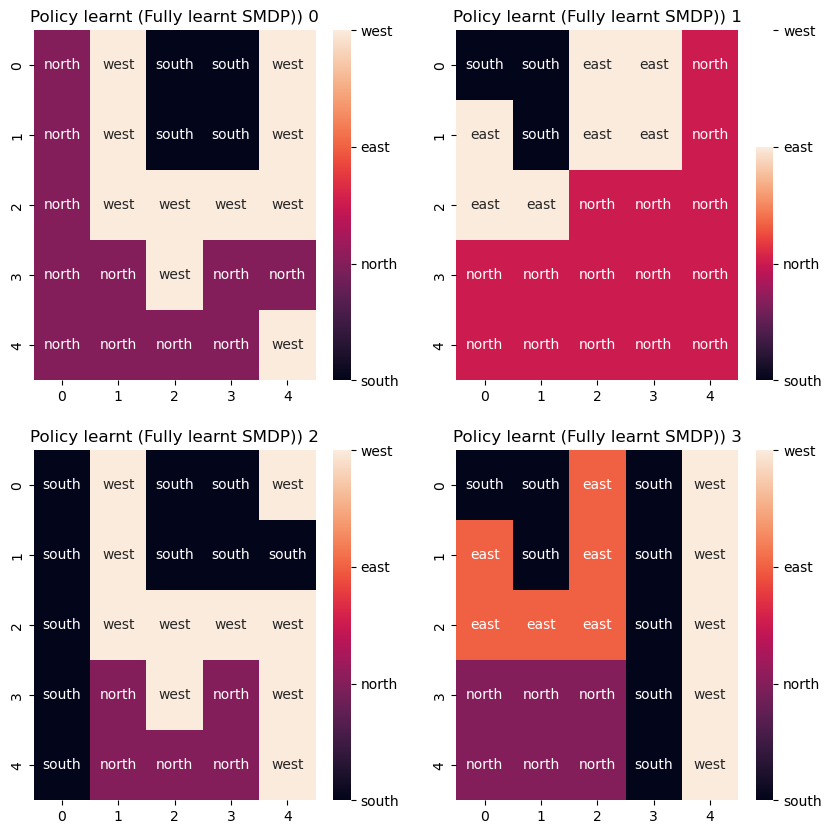

In [37]:
figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    labels = {0:'south',1:'north', 2:'east', 3:'west'}
    annot_text = np.vectorize(labels.get)(np.argmax(Q_options[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Q_options[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='')
    axis[i,j].set_title("Policy learnt (Fully learnt SMDP)) {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])


## Intra Options 

In [217]:
nPas = 5
nDrop = 4
gamma = 0.9  # Discount factor
alpha = 0.1  # Learning rate
nO = 4 
nX = 5
nY = 5
nPas = 5
nDrop = 4

eps_decay = 0.99
eps_min = 0.01

Neps = 1500

goal = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}  # Goal positions for passengers and drops

In [234]:
def Sub(state, nPas = nPas, nDrop = nDrop):
  _,_,pas,drop = env.decode(state) 
  subState = nDrop*pas+drop 
  return subState 

def Option(env,state,Q,goalNum,eps=0.1,goal = goal):
  optdone = False
  x,y,pas,drop=env.decode(state)
  
  if (x==goal[goalNum][0] and y==goal[goalNum][1]):
      #print('Reached ',goalNum)
      optdone = True 
      if pas == goalNum:
        optact = 4
      elif drop == goalNum:
        optact = 5 
      else:   
        optact = 1 if (goalNum in [0,1]) else 0
  else:
    optact = egreedy_policy(Q[goalNum], 5*x+y, epsilon=eps) 
  return [optact,optdone]

In [283]:
# Initialize Q-values for each option
Qopt = {i: np.zeros((nX * nY, env.action_space.n - 2)) for i in range(nO)}  # Subtracting pick,drop
q_values_IOQL = np.zeros((nPas* nDrop, nO))
tot_epoch = 0

def IntraOptions_QLearning(render = None):
  global tot_epoch
  rewards = []  # To store rewards per episode
  eps_main = 0.5
  count = 0
  updates_IOQL = np.zeros((nPas* nDrop, nO))
  eps = {i:0.1 for i in range(nO)}
  T = 1

  for i in range(Neps):
    state = env.reset()    
    done = False
    tot_rew=0

    while not done:
        
        _,_,pas,drop = env.decode(state) 
        subState = nDrop*pas+drop      
        action = egreedy_policy(q_values_IOQL, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_main*eps_decay)

        option = action
        optdone = False
        prev = state  

        while not optdone and not done:

            optact,optdone = Option(env,state,Qopt,option,eps[option])
            next_state, reward, done,_ = env.step(optact)
            tot_rew+=reward
            [x,y,_,_]=  list(env.decode(state)) 
            [x1,y1,_,_]=  list(env.decode(next_state)) 

            if render is not None:
                clear_output(wait=True)
                print(env.render())
                time.sleep(T)

            eps[option] = max(eps_min,eps_decay*eps[option])
            if optdone:
              reward_surr = 10
            else : 
               reward_surr = reward
            
            if optact<4:  
              Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])
            
            for o in range(nO):
              optact_o,optdone_o = Option(env,state,Qopt,o,eps[o])
              if optact_o == optact:
                eps[o] = max(eps_min,eps_decay*eps[o])
                if optdone_o:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*np.max(q_values_IOQL[Sub(next_state), :]) - q_values_IOQL[Sub(state), o])
                else:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*q_values_IOQL[Sub(next_state), o] - q_values_IOQL[Sub(state), o]) 

                updates_IOQL[Sub(state), o] += 1
            tot_epoch += 1
            state = next_state 
        
    rewards.append(tot_rew)
    x,y,pas,drop = env.decode(state)

    if pas==drop:
      count+=1
      # clear_output(wait=True)
      print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))
      
  return rewards

rewards_ioql = IntraOptions_QLearning()
print(tot_epoch/num_episodes)

Success (1/12) = 8.333333333333334%
Success (2/14) = 14.285714285714286%
Success (3/15) = 20.0%
Success (4/17) = 23.529411764705884%
Success (5/18) = 27.77777777777778%
Success (6/19) = 31.57894736842105%
Success (7/21) = 33.333333333333336%
Success (8/22) = 36.36363636363637%
Success (9/23) = 39.130434782608695%
Success (10/24) = 41.666666666666664%
Success (11/25) = 44.0%
Success (12/26) = 46.15384615384615%
Success (13/27) = 48.148148148148145%
Success (14/28) = 50.0%
Success (15/29) = 51.724137931034484%
Success (16/31) = 51.61290322580645%
Success (17/32) = 53.125%
Success (18/33) = 54.54545454545455%
Success (19/34) = 55.88235294117647%
Success (20/35) = 57.142857142857146%
Success (21/36) = 58.333333333333336%
Success (22/37) = 59.45945945945946%
Success (23/38) = 60.526315789473685%
Success (24/39) = 61.53846153846154%
Success (25/40) = 62.5%
Success (26/41) = 63.41463414634146%
Success (27/42) = 64.28571428571429%
Success (28/43) = 65.11627906976744%
Success (29/44) = 65.90909

7.8


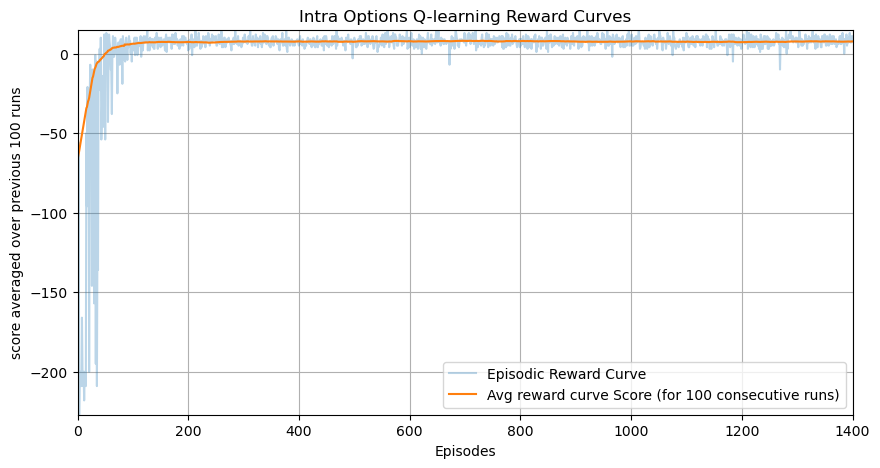

In [265]:
plt.figure(figsize = (10,5))
avg_rews_ioql = [np.average(rewards_ioql[i:i+100]) for i in range(len(rewards_ioql)-100)]
# plt.plot([9.7 for i in range(len(avg_rews))],label = 'Solved line')
plt.plot(rewards_ioql,label = 'Episodic Reward Curve', alpha=0.3)
plt.plot(avg_rews,label = 'Avg reward curve Score (for 100 consecutive runs)')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('Intra Options Q-learning Reward Curves')
plt.ylim([np.min(rewards_ioql),np.max(rewards_ioql)])
plt.xlim([0,1400])
plt.legend()
plt.grid()
print(avg_rews_ioql[-1])

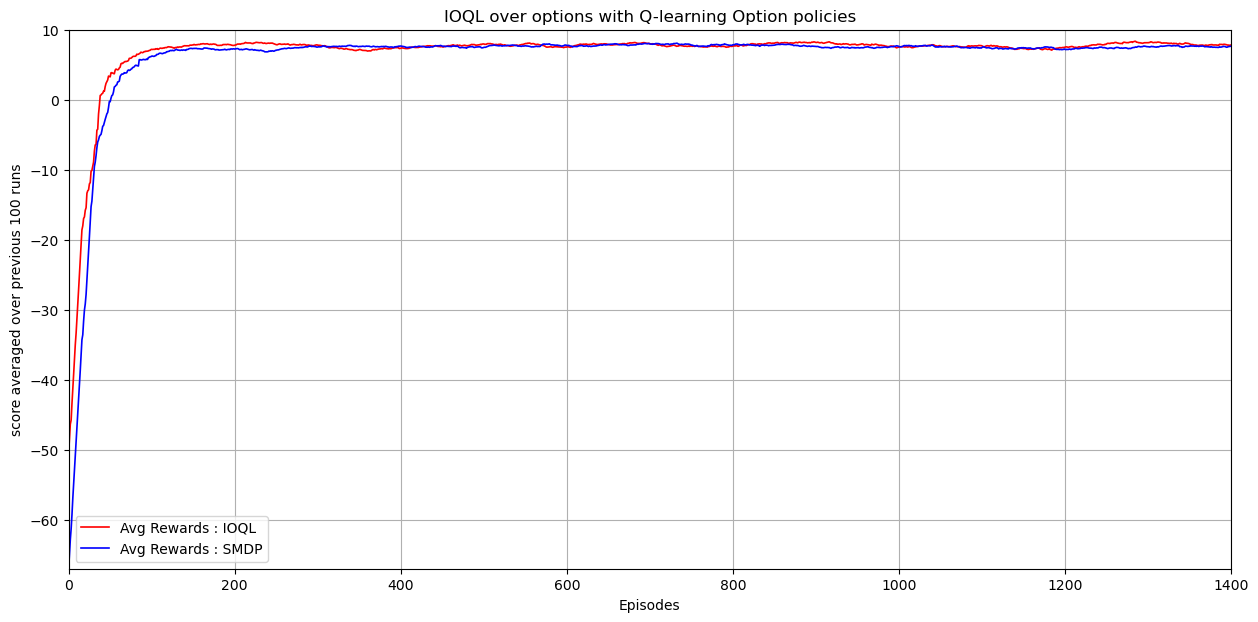

In [266]:
plt.figure(figsize = (15,7))
avg_rews_ioql = [np.average(rewards_ioql[i:i+100]) for i in range(len(rewards_ioql)-100)]
plt.plot(avg_rews_ioql,label = 'Avg Rewards : IOQL', color='red', linewidth = 1.2)
plt.plot(avg_rews,label = 'Avg Rewards : SMDP', color='blue', linewidth = 1.2)
# plt.plot([9.7 for i in range(len(avg_rews_ioql))],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('IOQL over options with Q-learning Option policies')
plt.ylim([np.min(avg_rews),10])
# plt.ylim([0,10])
plt.xlim([0,1400])
plt.legend()
plt.grid()

In [48]:
def visualize_steps(models) : 
    plt.figure(figsize=(10,5))
    for color, reward in models.items() : 
        episodes = len(reward)
        limit = 100
        ul = episodes + 1 - limit
        std_steps = np.std(reward)
        avg_reward = [np.average(reward[i:i+limit]) for i in range(len(reward)-limit)]
        # Plot steps to completion
        reward = np.reshape(reward, (episodes,))
        plt.plot(range(1, ul), avg_reward, label= 'SMDP' if color == 'red' else 'IOQL' ,color=color)
        plt.fill_between(range(1, ul), reward[1:1501-limit] - std_steps, reward[1:1501-limit] + std_steps, color=color, alpha=0.3)

    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title('Steps to Completion')
    plt.legend()
    plt.show()


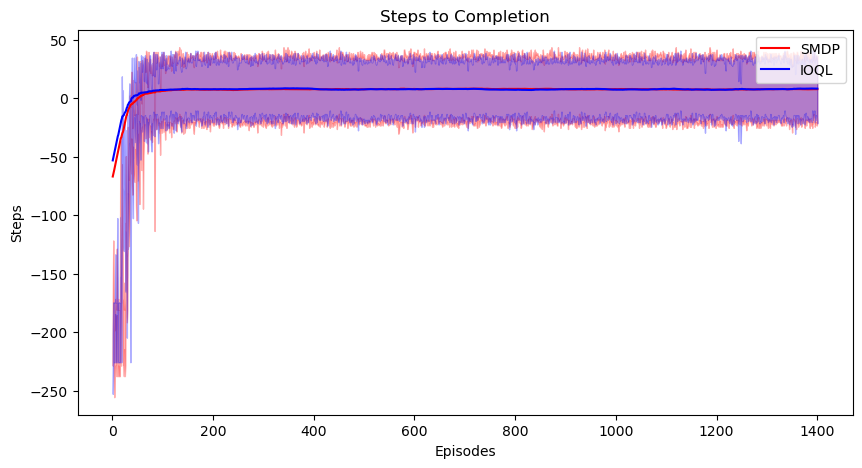

In [195]:
visualize_steps({'red': rewards,'blue': rewards_ioql})

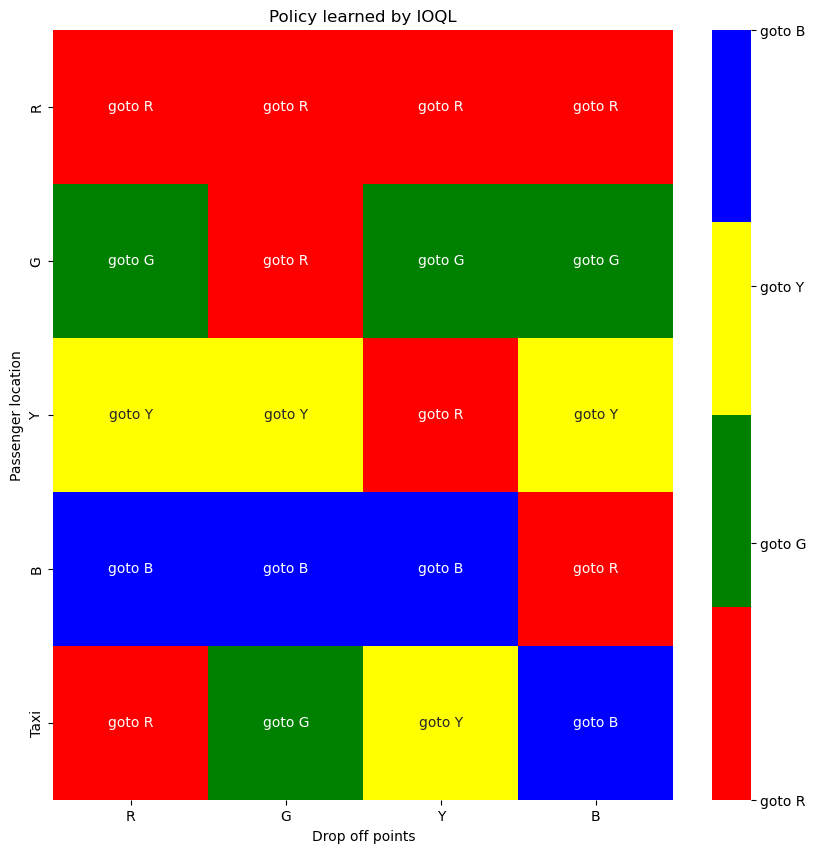

In [196]:
Qmax_IOQL = np.argmax(q_values_IOQL, axis=1).reshape(5,4)
HeatMapPlot(Qmax_IOQL, 'Policy learned by IOQL')

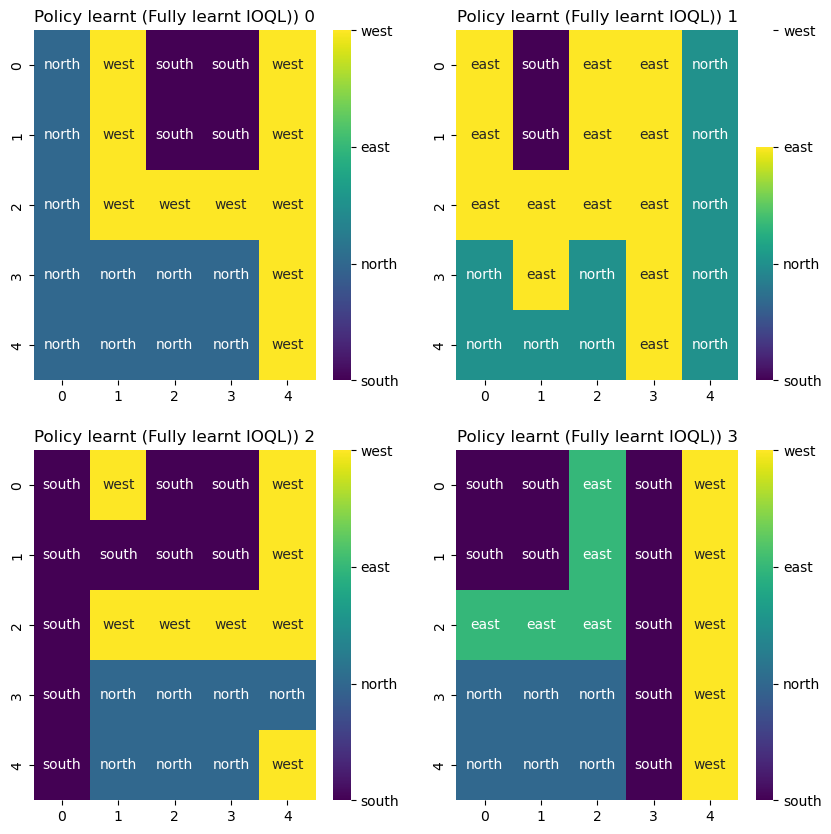

In [284]:
figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    labels = {0:'south',1:'north', 2:'east', 3:'west'}
    annot_text = np.vectorize(labels.get)(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='',cmap='viridis')
    axis[i,j].set_title("Policy learnt (Fully learnt IOQL)) {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])


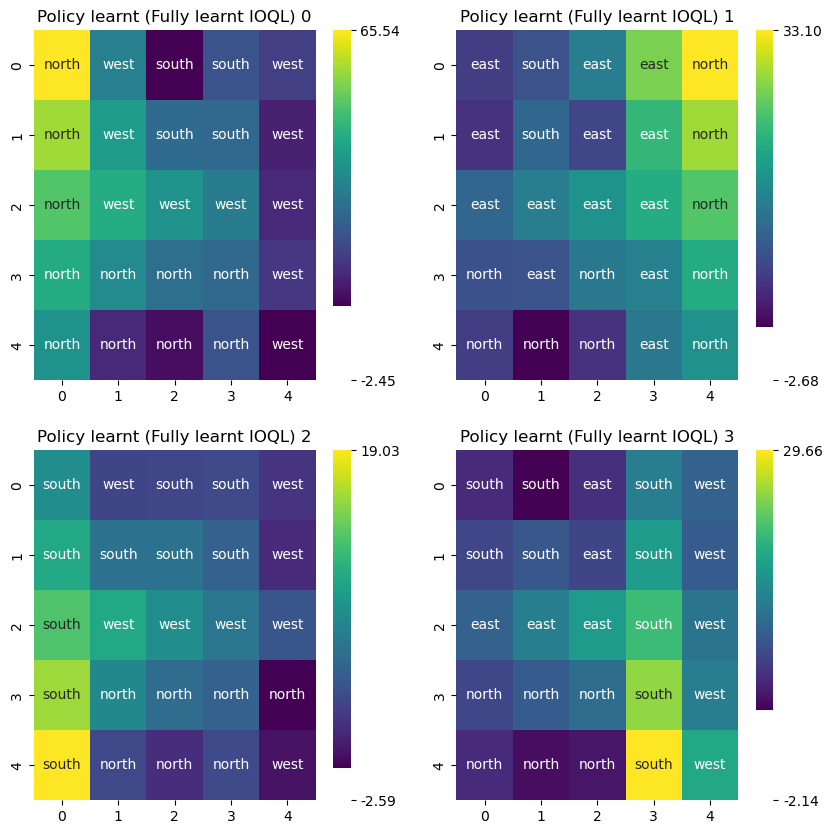

In [285]:
figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
    for j in range(2):
        # Define labels for actions
        labels = {0: 'south', 1: 'north', 2: 'east', 3: 'west'}
        
        # Generate annotation text for heatmap
        annot_text = np.vectorize(labels.get)(np.argmax(Qopt[2*i+j], axis=1).reshape(5, 5))
        
        # Plot heatmap
        ax = sns.heatmap(np.max(Qopt[2*i+j], axis=1).reshape(5, 5), ax=axis[i, j], annot=annot_text, fmt='', cmap="viridis")
        
        # Set title for subplot
        axis[i, j].set_title("Policy learnt (Fully learnt IOQL) {}".format(i*2+j))
        
        # Customize color bar ticks and labels
        c_bar = ax.collections[0].colorbar
        q_min = np.min(Qopt[2*i+j])
        q_max = np.max(Qopt[2*i+j])
        c_bar.set_ticks([q_min, q_max])  # Set ticks to min and max values
        c_bar.set_ticklabels(['{:.2f}'.format(q_min), '{:.2f}'.format(q_max)])  # Set numerical labels for the ticks

plt.show()


In [210]:
# Number of options
num_options = 4

# Goal locations
goals = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}

# Define option function
def Options_frame_1(env, state, Q, option_num, eps=0.1, goals=goals):
    opt_done = False
    x, y, passenger, dropoff = env.decode(state)


    # Move according to the specified option
    if option_num == 0:  # Move up
        opt_act = 1  # north
    elif option_num == 1:  # Move down
        opt_act = 0  # south
    elif option_num == 2:  # Move left
        opt_act = 2  # west
    elif option_num == 3:  # Move right
        opt_act = 3  # east

    # Check if the option is complete

    ((goal_x, goal_y),pa) = (goals[passenger],0) if passenger != 4 else (goals[dropoff],1)
    if x == goal_x or y== goal_y:
        opt_done = True
    if x == goal_x and y == goal_y:
      if pa ==0:
        opt_act=4
      else:
        opt_act=5


    return [opt_act, opt_done]

'''
Now the new action space will contain
Primitive Actions: ["south", "north", "east", "west","pick","drop"]
Options: ["Move_up","Move_down","Move_left","Move_right"]
Total Actions :["south", "north", "east", "west","pick","drop","Move_up","Move_down","Move_left","Move_right"]
Corresponding to [0,1,2,3,4,5,6,7,8,9]
'''

# Rest of your code goes here...


'\nNow the new action space will contain\nPrimitive Actions: ["south", "north", "east", "west","pick","drop"]\nOptions: ["Move_up","Move_down","Move_left","Move_right"]\nTotal Actions :["south", "north", "east", "west","pick","drop","Move_up","Move_down","Move_left","Move_right"]\nCorresponding to [0,1,2,3,4,5,6,7,8,9]\n'

In [211]:
# Initialize Q-values for each option
Qopt = {i: np.zeros((nX * nY, env.action_space.n - 2)) for i in range(nO)}  # Subtracting pick,drop
q_values_IOQL = np.zeros((nPas* nDrop, nO))
tot_epoch = 0

def IntraOptions_QLearning(render = None):
  global tot_epoch
  rewards = []  # To store rewards per episode
  eps_main = 0.5
  count = 0
  updates_IOQL = np.zeros((nPas* nDrop, nO))
  eps = {i:0.1 for i in range(nO)}
  T = 1

  for i in range(Neps):
    state = env.reset()    
    done = False
    tot_rew=0

    while not done:
        
        _,_,pas,drop = env.decode(state) 
        subState = nDrop*pas+drop      
        action = egreedy_policy(q_values_IOQL, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_main*eps_decay)

        option = action
        optdone = False
        prev = state  

        while not optdone and not done:

            optact,optdone = Options_frame_1(env,state,Qopt,option,eps[option])
            next_state, reward, done,_ = env.step(optact)
            tot_rew+=reward
            [x,y,_,_]=  list(env.decode(state)) 
            [x1,y1,_,_]=  list(env.decode(next_state)) 

            if render is not None:
                clear_output(wait=True)
                print(env.render())
                time.sleep(T)

            eps[option] = max(eps_min,eps_decay*eps[option])
            if optdone:
              reward_surr = 10
            else : 
               reward_surr = reward
            
            if optact<4:  
              Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])
            
            for o in range(nO):
              optact_o,optdone_o = Options_frame_1(env,state,Qopt,o,eps[o])
              if optact_o == optact:
                eps[o] = max(eps_min,eps_decay*eps[o])
                if optdone_o:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*np.max(q_values_IOQL[Sub(next_state), :]) - q_values_IOQL[Sub(state), o])
                else:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*q_values_IOQL[Sub(next_state), o] - q_values_IOQL[Sub(state), o]) 

                updates_IOQL[Sub(state), o] += 1
            tot_epoch += 1
            state = next_state 
        
    rewards.append(tot_rew)
    x,y,pas,drop = env.decode(state)

    if pas==drop:
      count+=1
      # clear_output(wait=True)
      print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))
      
  return rewards

rewards_ioql_1 = IntraOptions_QLearning()
print(tot_epoch/num_episodes)

Success (1/25) = 4.0%
Success (2/107) = 1.8691588785046729%
Success (3/120) = 2.5%
Success (4/206) = 1.941747572815534%
Success (5/244) = 2.0491803278688523%
Success (6/295) = 2.0338983050847457%
Success (7/335) = 2.08955223880597%
Success (8/339) = 2.359882005899705%
Success (9/386) = 2.33160621761658%
Success (10/409) = 2.444987775061125%
Success (11/410) = 2.682926829268293%
Success (12/449) = 2.6726057906458798%
Success (13/457) = 2.8446389496717726%
Success (14/459) = 3.0501089324618738%
Success (15/496) = 3.024193548387097%
Success (16/500) = 3.2%
Success (17/548) = 3.102189781021898%
Success (18/597) = 3.0150753768844223%
Success (19/603) = 3.1509121061359866%
Success (20/628) = 3.1847133757961785%
Success (21/653) = 3.215926493108729%
Success (22/661) = 3.3282904689863844%
Success (23/828) = 2.7777777777777777%
Success (24/864) = 2.7777777777777777%
Success (25/873) = 2.86368843069874%
Success (26/1000) = 2.6%
Success (27/1040) = 2.5961538461538463%
Success (28/1056) = 2.651515

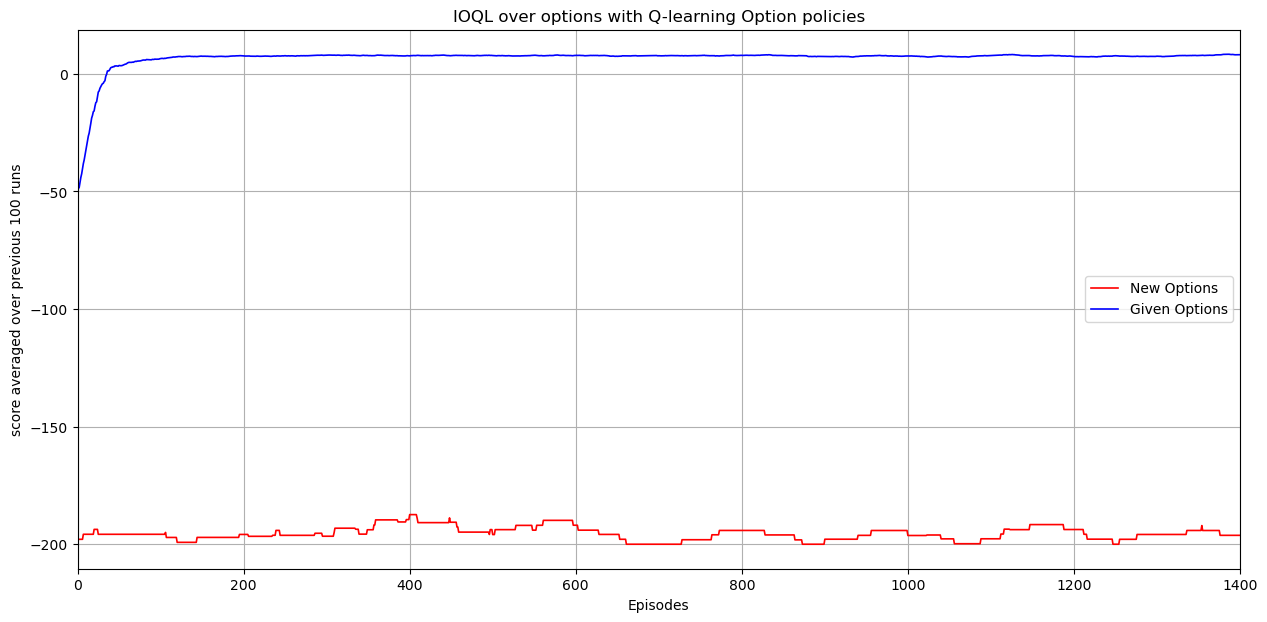

In [215]:
plt.figure(figsize = (15,7))
avg_rews_ioql_1 = [np.average(rewards_ioql_1[i:i+100]) for i in range(len(rewards_ioql_1)-100)]
plt.plot(avg_rews_ioql_1,label = 'New Options', color='red', linewidth = 1.2)
plt.plot(avg_rews_ioql, label = 'Given Options', color='blue', linewidth = 1.2)
# plt.plot(avg_rews,label = 'Avg Rewards : SMDP', color='blue', linewidth = 1.2)
# plt.plot([9.7 for i in range(len(avg_rews_ioql))],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('IOQL over options with Q-learning Option policies')
# plt.ylim([np.min(avg_rews),10])
# plt.ylim([0,10])
plt.xlim([0,1400])
plt.legend()
plt.grid()